In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

This notebook is a step by step walk through of the manifold capacity and geometries algorithm in Chou2025b (algorithm 2).  

I will begin by creating two point clouds in 2D space clearly visible separate and the walk through the algorithm step by step to understand it. 

Having it in 2D will make all the vectors easily visible to understand how the algorithm is working. 

In [2]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from cvxopt import matrix, solvers
from jaxopt import OSQP

In [3]:
mu1, mu2 = jnp.array([2,2]), jnp.array([-1,-1])
sigma = 0.3
sigma = sigma*jnp.array([[1,0],[0,1]])
key = jax.random.PRNGKey(1)
cloud1_key, cloud2_key, key = jax.random.split(key, 3)

In [4]:
P = 2
n_points_per_cloud = 40
M = 5
N = 2
n_t = 40
cloud1 = jax.random.multivariate_normal(cloud1_key, mu1, sigma, (n_points_per_cloud,))
cloud2 = jax.random.multivariate_normal(cloud2_key, mu2, sigma, (n_points_per_cloud,))
all_data = jnp.stack([cloud1, cloud2])


In [5]:
# n_data_points = all_data.shape[1]
# m_key = jax.random.PRNGKey(40)
# def sample_m(k):
#     return jax.random.choice(k, n_data_points, shape=(M,), replace=False)
# mp_keys = jax.random.split(m_key, P)
# m_axes = jax.vmap(sample_m, in_axes=(0))(mp_keys)
# print(f"{m_axes.shape=}")
# m_data = jax.vmap(lambda d,indcs: d[indcs,:])(all_data, m_axes)
# print(f"{m_data.shape=}")


## Glue Class implementation Testing

In [6]:
from glue_module.glue_analysis import glue_solver
gs_key = jax.random.PRNGKey(44)

In [7]:
gs = glue_solver(gs_key, P, M, N, n_t)
print(f"{all_data.shape=}")
geos = gs.run(all_data)
print(geos)
gs.all_t_ks.shape

all_data.shape=(2, 40, 2)


TypeError: vmap() missing 1 required positional argument: 'fun'

## Step through of GLUE analysis

### Create Data
Randomly sample from two means.


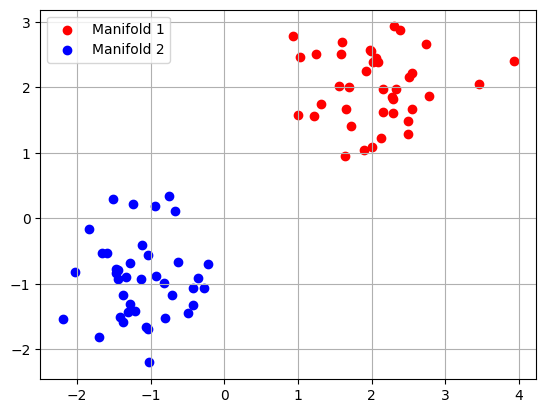

In [ ]:
plt.scatter(cloud1[:,0], cloud1[:,1], label='Manifold 1', color='r')
plt.scatter(cloud2[:,0], cloud2[:,1], label='Manifold 2', color='b')
plt.legend()
plt.grid(True, which='major')
plt.show()

#### inputs
P point clouds = 2 point clouds
M points sampled from each cloud
n_t number of t and y samples for expectation

In [ ]:
M = 3

In [ ]:
# Randomly sample M points from each cloud
c1_m_key, c2_m_key, key = jax.random.split(key, 3)  # pyright: ignore[reportAny]
cloud1_M = jax.random.choice(c1_m_key, cloud1, (M,), axis=0, replace=False)  # pyright: ignore[reportAny]
cloud2_M = jax.random.choice(c2_m_key, cloud2, (M,), axis=0, replace=False)  # pyright: ignore[reportAny]

In [ ]:
# hyper parameters
P = 2
N = 2
n_t = 40
t_mu = jnp.zeros(N)
t_sigma = jnp.eye(N)

t_key, y_key, key = jax.random.split(key, 3)
y_dichotomies = jnp.array([[-1,1],[1,-1]])
# y_dichotomies = jnp.array([[-1,1]])
n_dichotomies = 1

# constants
A = jnp.eye(N)
H = jnp.zeros((P*M, 1))

# pre-compute all random variables
all_t_ks = jax.random.multivariate_normal(t_key, t_mu, t_sigma, (n_t,))
print(f"{all_t_ks.shape=}")
all_y = jax.random.choice(y_key, y_dichotomies, (n_t,), axis=0)
print(f"{all_y.shape=}")
qp = OSQP(tol=1e-4)

all_anchor_points = jnp.zeros((P, n_t, N))
all_w = jnp.zeros((n_t, N))
all_primals = jnp.zeros((n_t, N))


all_t_ks.shape=(40, 2)
all_y.shape=(40, 2)


In [ ]:
# cloud points: 3 points with 2 features each, N=2
print(f"{cloud1_M.shape=}\n{cloud2_M.shape=}")

cloud1_M.shape=(3, 2)
cloud2_M.shape=(3, 2)


### Single Step walkthrough


#### First Step
Setting up our random probe and dichotomy, $t_k$ and $y$ respectively.

In [ ]:
t_k = jnp.expand_dims(all_t_ks[0], axis=1)
y = jnp.expand_dims(all_y[0], axis=1)
q_t = -1 * t_k 
print(f"{q_t.shape=}")

q_t.shape=(2, 1)


- Setting up G


We set up the matrix of constraints which is P*MxN.
This corresponds to the y_i*s_i_j where i is the class and j is the point from the class.

In [ ]:
# G is the vector with P * M x N points, where each M points in P_i is multiplied by its dichotomy. 
G = jnp.concatenate([y[0] * cloud1_M, y[1]*cloud2_M])
# check G:
print(f"{G.shape=}")
print(f"{G}")

G.shape=(6, 2)
[[1.311928   1.7503703 ]
 [2.5090687  2.1607673 ]
 [1.5526493  2.0141635 ]
 [1.4468338  0.9258755 ]
 [0.48542053 1.4466676 ]
 [1.2132806  1.4076238 ]]


In [ ]:
# Now we set up the qp() solver
sol = qp.run(params_obj=(A, q_t), params_eq=None, params_ineq=(G, H)).params

In [ ]:
# the params is a KKTSolution object with primal, dual_eq, and dual_ineq entries. 
print(sol)
primal = sol.primal
z_dual = sol.dual_ineq
print(f"{z_dual.shape=}")
# these also are the lagrange multipliers, equal to the number of constraints in Gx<=h. Since we have P * M points, we'll have P * M lagrange multipliers.
# We set up the inverse problem of finding the space of negated dual cones so that when they use qp() to solve it, it inverts the problem to use lagrange multipliers.
# the larger the multipliers, the more active that constraint is, a support vector. 

KKTSolution(primal=Array([[ 0.6915404],
       [-1.0806154]], dtype=float32), dual_eq=None, dual_ineq=Array([[0.       ],
       [0.       ],
       [0.       ],
       [0.9176074],
       [0.       ],
       [0.       ]], dtype=float32))
z_dual.shape=(6, 1)


In [ ]:
"""G is the matrix of y*s points. 
The constraints are asking which vector x will separate G points from the origin.
Or, the projection of the G points on to the vector x will be the negative projection. 
the primal is the projection on to the negative dual cone"""
G @ primal

Array([[-9.8422587e-01],
       [-5.9983611e-01],
       [-1.1028163e+00],
       [ 2.8729439e-05],
       [-1.2276033e+00],
       [-6.8206739e-01]], dtype=float32)

In [ ]:
# to get the part of t that is a solution to classifying points correctly, we subtract t - x = w
# if w exisits, then a linear classifier exists for this probe t and dichotomy y
w = t_k[:,0] - primal[:,0]
print(f"{w=}")
print(f"{G @ w =}")
print(f"{cloud1_M @ w=}")
print(f"{cloud2_M @ w=}")

w=Array([1.3275421, 0.8494971], dtype=float32)
G @ w =Array([3.228574 , 5.16646  , 3.7722332, 2.7072613, 1.8733561, 2.8064532],      dtype=float32)
cloud1_M @ w=Array([3.228574 , 5.16646  , 3.7722332], dtype=float32)
cloud2_M @ w=Array([-2.7072613, -1.8733561, -2.8064532], dtype=float32)


Now with a solution for our qp(), we use the lagrange multipliers to derive an anchor point as a scaled vector of all points for each class. <br>
To calculate the anchor point, we scale each point by the langrange multipliers and then sum them:<br>
$$ s_i[k] = \frac{\sum_j^M \lambda_{i,j} y_i \mathbf{s}_{i,j}}{\sum_j^M \lambda_{i,j}}$$

In [ ]:
def safe_divide(numerator, denominator, fill_value=0.0):
    """
    Performs division using jax.lax.div, returning fill_value where denominator is 0.
    """
    # 1. Create a mask where the denominator is NOT zero
    # We assume standard float comparison; for integers, logic is identical.
    mask = jax.lax.ne(denominator, 0.0)
    
    # 2. Create a "safe" denominator. 
    # We replace 0 with 1 to avoid generating NaNs/Infs during the calculation.
    # This is safer for gradients than simply dividing and masking afterwards.
    safe_denominator = jax.lax.select(mask, denominator, jnp.ones_like(denominator))
    
    # 3. Perform the raw division using the requested lax primitive
    raw_div = jax.lax.div(numerator, safe_denominator)
    
    # 4. Select the division result where mask is True, otherwise use fill_value
    # Ensure fill_value matches the shape/type of the result
    safe_fill = jnp.full_like(raw_div, fill_value)
    
    return jax.lax.select(mask, raw_div, safe_fill)
    

In [ ]:
lambda_p_x_m = z_dual.squeeze().reshape(2,M)
print(f"{lambda_p_x_m.shape=}")
print(f"{lambda_p_x_m=}")
G_p_x_m = G.reshape(2,M,-1)
print(f"{G=}")
print(f"{G_p_x_m=}")
print(G_p_x_m.shape)
anchor_points = jax.vmap(safe_divide, in_axes=(0,0))(jnp.sum((lambda_p_x_m.T * G_p_x_m.T).T, axis=1), jnp.sum(lambda_p_x_m, axis=1))
anchor_points_np = np.expand_dims(np.array(anchor_points), axis=-1)
anchor_points

lambda_p_x_m.shape=(2, 3)
lambda_p_x_m=Array([[0.       , 0.       , 0.       ],
       [0.9176074, 0.       , 0.       ]], dtype=float32)
G=Array([[1.311928  , 1.7503703 ],
       [2.5090687 , 2.1607673 ],
       [1.5526493 , 2.0141635 ],
       [1.4468338 , 0.9258755 ],
       [0.48542053, 1.4466676 ],
       [1.2132806 , 1.4076238 ]], dtype=float32)
G_p_x_m=Array([[[1.311928  , 1.7503703 ],
        [2.5090687 , 2.1607673 ],
        [1.5526493 , 2.0141635 ]],

       [[1.4468338 , 0.9258755 ],
        [0.48542053, 1.4466676 ],
        [1.2132806 , 1.4076238 ]]], dtype=float32)
(2, 3, 2)


Array([[0.        , 0.        ],
       [1.446834  , 0.92587554]], dtype=float32)

In [ ]:
def plot_cone_geometry(P: int,
                       G_jnp: jnp.ndarray, 
                       M: int, 
                       t_k_jnp: jnp.ndarray, 
                       primal_jnp: jnp.ndarray,
                       anchor_points = None):
   
    """
    Plots a figure showing data cones, projections, and anchor points.
    Automatically detects if data is 2D or 3D and renders accordingly.

    Args:
        P (int): Number of classes.
        G (jax.Array): Matrix of shape (P*M, N). N determines dimension (2 or 3).
        M (int): Number of points per class.
        t_ks (array-like): Random Probe vector.
        primal_jnp (array-like): Primal vector.
        anchor_points (jax.Array, optional): Matrix of anchor points.
    """
    # --- 1. Data Preparation ---
    G = np.array(G_jnp)
    t_k = np.array(t_k_jnp).flatten()
    primal = np.array(primal_jnp).flatten()
    w = t_k - primal # Moreau Decomposition: t = w + primal

    # Detect Dimension (2 or 3)
    dim = G.shape[-1]

    # Reshape G to (P, M, dim)
    points_per_class = G.reshape(P, M, dim)

    # --- 2. Dynamic Range Calculation ---
    # Stack all coordinates to find global max for axis scaling
    all_points_list = [G, t_k.reshape(1, -1), primal.reshape(1, -1), w.reshape(1, -1)]
    if anchor_points is not None:
        anchor_np = np.array(anchor_points)
        all_points_list.append(anchor_np)

    all_coords = np.vstack(all_points_list)
    max_abs_val = np.max(np.abs(all_coords))
    range_val = max_abs_val + 0.5
    line_multiplier = range_val * 3.0 # Ensure lines go off-screen

    # Initialize Figure
    fig = go.Figure()

    # Color Palette
    base_colors = px.colors.qualitative.Plotly
    class_colors = (base_colors * (P // len(base_colors) + 1))[:P]

    # --- 3. Factories (The Smart Wrappers) ---
    
    def make_scatter(coords, **kwargs):
        """
        Factory: Returns go.Scatter or go.Scatter3d based on 'dim'.
        Automatically slices coords into x, y, (z).
        """
        # Ensure coords is 2D array even for single points
        if coords.ndim == 1:
            coords = coords.reshape(1, -1)
            
        common_args = dict(x=coords[:, 0], y=coords[:, 1], **kwargs)
        
        if dim == 3:
            return go.Scatter3d(z=coords[:, 2], **common_args)
        else:
            return go.Scatter(**common_args)

    def create_ray_lines(points, color, name, group):
        """
        Helper to generate the [Origin -> Point -> None] data structure 
        for drawing multiple lines in a single trace.
        """
        # Pre-allocate arrays including the `None` spacers
        # Shape: (NumPoints * 3, Dim) -> [0,0], [x,y], [None, None]...
        num_points = points.shape[0]
        ray_coords = np.full((num_points * 3, dim), np.nan) 
        
        # Fill Origins (0,0,...)
        ray_coords[0::3] = 0 
        # Fill Endpoints (point * multiplier)
        ray_coords[1::3] = points * line_multiplier
        # The 3rd indices [2::3] remain NaN to break the lines
        
        return make_scatter(
            ray_coords,
            mode='lines',
            line=dict(color=color, width=1, dash='dash'),
            opacity=0.3,
            name=f"{name} Cone",
            legendgroup=group,
            hoverinfo='skip'
        )

    # --- 4. Add Traces ---

    # A. Classes (Points + Cones)
    for i in range(P):
        current_points = points_per_class[i]
        color = class_colors[i]
        group_id = f"group{i}"
        
        # 1. Cone Rays
        fig.add_trace(create_ray_lines(current_points, color, f"Class {i+1}", group_id))
        
        # 2. Points
        fig.add_trace(make_scatter(
            current_points,
            mode='markers',
            name=f"Class {i+1} Points",
            legendgroup=group_id,
            marker=dict(size=5 if dim==3 else 10, color=color) # Smaller markers for 3D
        ))

    # B. Vectors
    # Helper to add single vectors easily
    def add_vec(vec, color, name):
        # Create a line from origin to vector
        origin = np.zeros((1, dim))
        line_data = np.vstack([origin, vec.reshape(1, dim)])
        
        fig.add_trace(make_scatter(
            line_data,
            mode='lines+markers',
            line=dict(color=color, width=4),
            marker=dict(size=4, color=color),
            name=name
        ))

    add_vec(t_k, 'purple', 'Random Probe (t)')
    add_vec(primal, 'green', 'Primal (x)')
    add_vec(w, 'orange', 'Dual/Polar (w)')

    # C. Anchor Points
    if anchor_points is not None:
        fig.add_trace(make_scatter(
            anchor_np,
            mode='markers',
            name="Anchor Points",
            marker=dict(size=10, color='black', opacity=0.5, symbol='diamond')
        ))

    # --- 5. Layout Factory ---
    
    layout_args = dict(
        height=400, width=600,
        title=f"Geometric Relationships ({dim}D, {P} Classes)",
        template="plotly_white",
        margin=dict(l=20, r=20, b=20, t=60),
    )

    if dim == 3:
        # 3D Specific Layout
        scene_dict = dict(
            xaxis=dict(range=[-range_val, range_val]),
            yaxis=dict(range=[-range_val, range_val]),
            zaxis=dict(range=[-range_val, range_val]),
            aspectmode='cube' # Crucial for 3D geometry to look correct
        )
        layout_args['scene'] = scene_dict
    else:
        # 2D Specific Layout
        layout_args.update(dict(
            xaxis=dict(range=[-range_val, range_val], zeroline=True, zerolinewidth=1, zerolinecolor='black'),
            yaxis=dict(
                range=[-range_val, range_val], 
                scaleanchor="x", 
                scaleratio=1,
                zeroline=True, zerolinewidth=1, zerolinecolor='black'
            )
        ))

    fig.update_layout(**layout_args)
    fig.show()

In [ ]:
def plot_cone_geometry_old(G, M, t_k, primal, w, anchor_points=None, range_val=6.4):
    """
    Plots a single figure showing data cones, projections, and anchor points.

    Args:
        G (np.array): Matrix of shape (P*M, N). First M rows are Class 1, next M are Class 2.
        M (int): Number of points per class.
        t_k (array-like): Random Probe vector.
        primal (array-like): Primal vector.
        w (array-like): Proj_cone t vector.
        anchor_points (np.array, optional): Matrix of anchor points.
        range_val (float): Axis limit magnitude.
    """
    
    # --- 1. Data Preparation ---
    # Flatten vectors to handle shape variations (e.g., (2,1) vs (2,))
    t_k = np.array(t_k).flatten()
    primal = np.array(primal).flatten()
    w = np.array(w).flatten()
    
    # Split G into classes
    c1_points = G[:M]
    c2_points = G[M:]

    # Initialize Figure
    fig = go.Figure()

    # --- 2. Helper Functions ---
    def get_cone_lines_trace(points, color, name):
        """Creates a single trace containing all lines from origin to edge through points"""
        x_lines, y_lines = [], []
        multiplier = range_val * 2.5  # Ensure line goes past the plot edge
        
        for point in points:
            # Line from (0,0) to (point_x * multiplier, point_y * multiplier)
            x_lines.extend([0, point[0] * multiplier, None])
            y_lines.extend([0, point[1] * multiplier, None])
            
        return go.Scatter(
            x=x_lines, y=y_lines,
            mode='lines',
            line=dict(color=color, width=1, dash='dash'),
            opacity=0.5,
            name=f"{name} Cone",
            hoverinfo='skip' # Don't show hover text for the background lines
        )

    def add_vector(vec, color, name):
        """Adds a vector from origin to point"""
        fig.add_trace(go.Scatter(
            x=[0, vec[0]], y=[0, vec[1]],
            mode='lines+markers',
            line=dict(color=color, width=3),
            marker=dict(size=8, color=color),
            name=name
        ))

    # --- 3. Add Traces ---

    # A. Cone Lines (Draw these first so they are behind points)
    fig.add_trace(get_cone_lines_trace(c1_points, 'blue', "Class 1"))
    fig.add_trace(get_cone_lines_trace(c2_points, 'red', "Class 2"))

    # B. Class Points
    fig.add_trace(go.Scatter(
        x=c1_points[:, 0], y=c1_points[:, 1],
        mode='markers', name="Class 1 Points",
        marker=dict(size=10, color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=c2_points[:, 0], y=c2_points[:, 1],
        mode='markers', name="Class 2 Points",
        marker=dict(size=10, color='red')
    ))

    # C. Vectors
    add_vector(t_k, 'purple', 'Random Probe')
    add_vector(primal, 'green', 'Primal')
    add_vector(w, 'orange', 'Proj_cone t')

    # D. Anchor Points (if provided)
    if anchor_points is not None:
        fig.add_trace(go.Scatter(
            x=anchor_points[:, 0], y=anchor_points[:, 1],
            name="Anchor Points",
            mode='markers',
            marker=dict(size=14, color='black', opacity=0.5, symbol='hexagram')
        ))

    # --- 4. Layout & Styling ---
    fig.update_layout(
        height=400, width=600,  # Square figure size
        title="Geometric Relationships",
        template="plotly_white",
        margin=dict(l=40, r=40, b=40, t=60),
    )

    # Force square aspect ratio on axes
    fig.update_xaxes(range=[-range_val, range_val], zeroline=True, zerolinewidth=1, zerolinecolor='black')
    fig.update_yaxes(
        range=[-range_val, range_val], 
        scaleanchor="x", 
        scaleratio=1, 
        zeroline=True, zerolinewidth=1, zerolinecolor='black'
    )

    fig.show()

In [ ]:
plot_cone_geometry(P, G, M, t_k, primal, anchor_points)
plot_cone_geometry_old(G, M, t_k, primal, w, anchor_points)

#### Second Step

In [ ]:
t_k = jnp.expand_dims(all_t_ks[8], axis=1)
y = jnp.expand_dims(all_y[8], axis=1)
q_t = -1 * t_k 
print(f"{t_k=}")

t_k=Array([[0.85059994],
       [1.7483382 ]], dtype=float32)


In [ ]:
# G is the vector with P * M x N points, where each M points in P_i is multiplied by its dichotomy. 
G = jnp.concatenate([y[0] * cloud1_M, y[1]*cloud2_M])
# check G:
print(f"{G.shape=}")
# print(f"{G}")

G.shape=(6, 2)


In [ ]:
sol = qp.run(params_obj=(A, q_t), params_eq=None, params_ineq=(G, H)).params

In [ ]:
print(sol)
primal = sol.primal
z_dual = sol.dual_ineq
print(f"{z_dual.shape=}")

KKTSolution(primal=Array([[0.85056585],
       [1.7483155 ]], dtype=float32), dual_eq=None, dual_ineq=Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32))
z_dual.shape=(6, 1)


In [ ]:
w = t_k[:,0] - primal[:,0]
print(f"{w=}")
print(f"{G @ w =}")

w=Array([3.4093857e-05, 2.2768974e-05], dtype=float32)
G @ w =Array([-8.4582818e-05, -1.3474228e-04, -9.8796241e-05, -7.0409384e-05,
       -4.9488997e-05, -7.3415562e-05], dtype=float32)


In [ ]:
lambda_p_x_m = z_dual.squeeze().reshape(P,M) # shape: (P*M,1) -> (P,M)
# print(f"{lambda_p_x_m.shape=}")
print(f"{lambda_p_x_m=}")
G_p_x_m = G.reshape(P,M,-1) # shape: (P*M, N) -> (P,M,N)
# print(f"{G=}")
# print(f"{G_p_x_m=}")
# print(G_p_x_m.shape)
anchor_points = jax.vmap(safe_divide, in_axes=(0,0))(jnp.sum((lambda_p_x_m.T * G_p_x_m.T).T, axis=1), jnp.sum(lambda_p_x_m, axis=1))
anchor_points_np = np.array(anchor_points)
print(f"Anchor Points:\n{anchor_points}")
print(f"G: \n{G}")

lambda_p_x_m=Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32)
Anchor Points:
[[0. 0.]
 [0. 0.]]
G: 
[[-1.311928   -1.7503703 ]
 [-2.5090687  -2.1607673 ]
 [-1.5526493  -2.0141635 ]
 [-1.4468338  -0.9258755 ]
 [-0.48542053 -1.4466676 ]
 [-1.2132806  -1.4076238 ]]


In [ ]:
plot_cone_geometry_old(G, M, t_k, primal, w, anchor_points)
plot_cone_geometry(P, G, M, t_k, primal, anchor_points)
# even if lagrange multipliers are small, they will be close to points, since z_dual*G/z_dual

When a random vector t is inside the negated dual cone, then no part of it can 

### Full Run:

In [ ]:
# def single_nt(t_ks, y_ks, )
m_data = jnp.stack([cloud1_M, cloud2_M], axis=0)


In [ ]:
#vmapped solving, no single function
all_q_t = -1 * all_t_ks
print(f"{all_q_t.shape=}")
all_G = jax.vmap(lambda x,y: x[:, None, None] * y, in_axes=(0,None))(all_y, m_data).reshape((n_t, -1, N)) # (n_t,P,M,N) -> (n_t,P*M,N)
all_G.shape

all_q_t.shape=(40, 2)


(40, 6, 2)

In [ ]:
sols = jax.vmap(lambda a, q, g, h: qp.run(params_obj=(a,q[:,None]), params_eq=None, params_ineq=(g,h)), in_axes=(None, 0, 0, None))(A, all_q_t, all_G, H)

In [ ]:
primals = sols.params.primal
print(f"{primals.shape=}")
duals = sols.params.dual_ineq
print(f"{duals.shape=}")

primals.shape=(40, 2, 1)
duals.shape=(40, 6, 1)


In [ ]:
all_lambdas = duals.reshape((n_t,P,M))
print(f"{all_lambdas.shape=}")
Gs_pm = all_G.reshape((n_t,P,M,N))
Gs_pm.shape

all_lambdas.shape=(40, 2, 3)


(40, 2, 3, 2)

In [ ]:
single_ap = lambda lam, gpm: jax.vmap(safe_divide, in_axes=(0,0))(jnp.sum((lam.T * gpm.T).T, axis=1), jnp.sum(lam, axis=1)) # vmap over P
all_anchor_points = jax.vmap(single_ap, in_axes=(0,0))(all_lambdas, Gs_pm) # vmap over n_t # shape: (n_t, P, N)
print(f"{all_anchor_points.shape=}")

all_anchor_points.shape=(40, 2, 2)


In [ ]:
# for k in range(0,n_t):
#     t_k = jnp.expand_dims(all_t_ks[k], axis=1) # all_t_ks.shape = (n_t,N)
#     y_k = jnp.expand_dims(all_y[k], axis=1) # all_y_k.shape = (n_t,P)
#     q_t = -1 * t_k 
#     # G = jnp.concatenate([y_k[0] * cloud1_M, y_k[1]*cloud2_M]) # improve to vmap for abstraction over P and Point Clouds
#     m_data = jnp.stack([cloud1_M, cloud2_M], axis=0)
#     # print(f"{m_data.shape}")
#     G = jnp.concatenate(jax.vmap(lambda a,b: a*b, in_axes=(0,0))(y_k, m_data),axis=0)
    
#     sol = qp.run(params_obj=(A, q_t), params_eq=None, params_ineq=(G, H)).params
#     primal = sol.primal
#     z_dual = sol.dual_ineq
#     lambda_p_x_m = z_dual.squeeze().reshape(P,M) # shape: (P*M,1) -> (P,M)
#     # print(f"{lambda_p_x_m.shape=}")
#     # print(f"{lambda_p_x_m=}")
#     G_p_x_m = G.reshape(P,M,-1) # shape: (P*M, N) -> (P,M,N)
#     # print(f"{G=}")
#     # print(f"{G_p_x_m=}")
#     # print(G_p_x_m.shape)
#     anchor_points = jax.vmap(safe_divide, in_axes=(0,0))(jnp.sum((lambda_p_x_m.T * G_p_x_m.T).T, axis=1), jnp.sum(lambda_p_x_m, axis=1))
#     all_anchor_points = all_anchor_points.at[:, k, :].set(anchor_points)
#     all_primals = all_primals.at[k,:].set(primal[:,0])

In [ ]:
# step 2: anchor center gram matrix
# take mean over n_t, axis=1 for anchor_points
s_0 = jnp.mean(all_anchor_points, axis=0) # shapes: (n_t,P,N) -> (P,N)
print(f"{s_0}\n{s_0.shape=}")
G_0 = s_0 @ s_0.T # shape: (PxN) @ (PxN).T = (P,P)
print(f"{G_0.shape=}")

# anchor point axis and variances
s_1k = jax.vmap(lambda x,y: x-y, in_axes=(1,0))(all_anchor_points, s_0)
print(f"{s_1k.shape=}")
t_1k = jax.vmap(lambda x,y: x@y.T, in_axes=(1,0))(s_1k, all_t_ks).transpose(1,0)
print(f"{t_1k.shape=}")
G_1k = jax.vmap(lambda x: x@x.T, in_axes=(1))(s_1k).transpose(1,2,0)
print(f"{G_1k.shape=}")

[[0.22702716 0.25079143]
 [0.3884529  0.3875403 ]]
s_0.shape=(2, 2)
G_0.shape=(2, 2)
s_1k.shape=(2, 40, 2)
t_1k.shape=(2, 40)
G_1k.shape=(2, 2, 40)


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=all_anchor_points[0,:,0], y=all_anchor_points[0,:,1], mode='markers', name='AP1',marker=dict(color='red',)))
fig.add_trace(go.Scatter(x=all_anchor_points[1,:,0], y=all_anchor_points[1,:,1], mode='markers', name='AP2',marker=dict(color='blue',)))
fig.add_trace(go.Scatter(x=[s_0[0,0]], y=[s_0[0,1]], mode='markers', name='AP1 Center',
            marker=dict(size=14, color='red', symbol='x')))
fig.add_trace(go.Scatter(x=[s_0[1,0]], y=[s_0[1,1]], mode='markers', name='AP2 Center',
            marker=dict(size=14, color='blue', symbol='x')))
fig.add_trace(go.Scatter(x=s_1k[0,:,0], y=s_1k[0,:,1], mode='markers', name='AP1 Axis',
            marker=dict(size=14, color='red', opacity=0.5, symbol='circle-open-dot')))
fig.add_trace(go.Scatter(x=s_1k[1,:,0], y=s_1k[1,:,1], mode='markers', name='AP2 Axis',
            marker=dict(size=14, color='blue', opacity=0.5, symbol='circle-open-dot')))
fig.update_layout(
    height=400, 
    width=600,
    template="plotly_white",
    margin=dict(l=40, r=40, b=40, t=60),
)
fig.show()

#### Manifold Metrics
capacity, dimension, radius, center alignment, axis alignment, center-axis alignment 

In [ ]:
def pinv_rtol(x, rtol=1e-4):
    return jnp.linalg.pinv(x,rtol=rtol)

In [ ]:
# capcity:
print(f"Shapes:\nAll anchor points: {all_anchor_points.shape}\nall_t_ks: {all_t_ks.shape}\n")
capacity = (1/P * jnp.mean(jax.vmap(lambda s,t: (s@t.T).T @ jnp.linalg.pinv(s@s.T) @ (s@t.T), in_axes=(1,0))(all_anchor_points, all_t_ks)))**(-1) # (P,n_t,N) , (n_t,N)
print(f"Capacity: {capacity}")

Shapes:
All anchor points: (2, 40, 2)
all_t_ks: (40, 2)

Capacity: 2.5844566822052


In [ ]:

dimension = (1/P * jnp.mean(jax.vmap(lambda t,g: t.T @ jnp.linalg.pinv(g) @ t, in_axes=(1,2))(t_1k, G_1k)))
print(f"Dimension: {dimension}")
def rad_top(t,g_1, g_0=G_0):
    return t.T @ jnp.linalg.pinv(g_1+g_0) @ t
def rad_bot(t,g_1,g_0=G_0):
    return t.T @ jnp.linalg.pinv(g_1 + (g_1 @ jnp.linalg.pinv(g_0) @ g_1)) @ t

rad_top_val = jax.vmap(lambda t,g: rad_top(t,g), in_axes=(1,2))(t_1k, G_1k)
rad_bot_val = jax.vmap(lambda t,g: rad_bot(t,g), in_axes=(1,2))(t_1k, G_1k)
rad_ratio = rad_top_val/rad_bot_val
# print(f"rad top val: \n{rad_top_val}")
# print(f"rad_bot_val: \n{rad_bot_val}")
# print(f"Rad Ratio: {rad_ratio}")
# print(f"Rad ratio sum: \n{jnp.sum(rad_ratio)}")
radius = jnp.sqrt(jnp.mean(jax.vmap(lambda t,g: rad_top(t,g)/rad_bot(t,g), in_axes=(1,2))(t_1k, G_1k)))
print(f"Radius: {radius}")
approx_capac = (1 + radius**(-2))/dimension
print(f"Approx Capacity: {approx_capac}")

from itertools import permutations
# get P class permutations
P_indices = jnp.array(list(permutations(range(P), r=2)))
center_align = 1/(P*(P-1)) * jnp.sum(
    jax.vmap(
        lambda x,y,pi: (x[pi[0]].T @ y[pi[1]])/(jnp.linalg.norm(x[pi[0]]) * jnp.linalg.norm(y[pi[1]])),
        in_axes=(None, None, 0))(s_0, s_0, P_indices)
)
print(f"Center Alignment: {center_align}")

def axis_align_nt_sum(s_ik, s_jk):
    # s_*ks shape: (n_t, N)
    top = lambda x,y: x@y.T # along N axis
    bot = lambda x,y: jnp.linalg.norm(x) * jnp.linalg.norm(y)
    frac = lambda x,y: top(x,y)/bot(x,y)
    return jnp.mean(jax.vmap(frac, in_axes=(0,0))(s_ik, s_jk))

axis_alignment = 1/(P*(P-1)) * jnp.sum(
    jax.vmap(
        lambda x,y, pid: axis_align_nt_sum(x[pid[0]],y[pid[1]]),
        in_axes=(None, None, 0))
        (s_1k, s_1k, P_indices)
        )
print(f"{axis_alignment=}")

def center_axis_align_nt_sum(s_0i, s_kj):
    # s_ks shape: (n_t, N)
    # s_0j shape: (1,N)
    top = lambda x,y: x@y.T # along N axis
    bot = lambda x,y: jnp.linalg.norm(x) * jnp.linalg.norm(y)
    frac = lambda x,y: top(x,y)/bot(x,y)
    return jnp.mean(jax.vmap(frac, in_axes=(None, 0))(s_0i, s_kj))

center_axis_alignment = 1/(P*(P-1)) * jnp.sum(
    jax.vmap(
        lambda x,y, pid: center_axis_align_nt_sum(x[pid[0]],y[pid[1]]),
        in_axes=(None, None, 0))
        (s_0, s_1k, P_indices)
        )

print(f"{center_axis_alignment=}")


Dimension: 1.0320918560028076
Radius: 40.91652297973633
Approx Capacity: 0.9694847464561462
Center Alignment: 0.9987065196037292
axis_alignment=Array(0.4228972, dtype=float32)
center_axis_alignment=Array(-0.37535727, dtype=float32)


In [ ]:
(s_0[0].T @ s_0[1]) / (jnp.linalg.norm(s_0[0]) * jnp.linalg.norm(s_0[1]))

Array(0.9987065, dtype=float32)

In [ ]:
# from itertools import product, combinations_with_replacement # I could use cwr for more structured dichotomy sampling
# k1 = jax.random.PRNGKey(45)
# k1, k2 = jax.random.split(k1)
# a = jnp.array([1,-1])
# yks = jax.random.choice(k1, a, shape=(10, P), replace=True, mode="low")
# print(f"{yks=}")
# non_dicht_mask = jnp.abs(jnp.sum(yks, axis=1))==P
# filler = jnp.concatenate([a]*P)[:P]
# print(f"{filler=}")
# n_fillers = int(jnp.sum(non_dicht_mask))
# repeated_filler = jnp.stack([filler,]*n_fillers, axis=0)
# print(f"{repeated_filler=}")
# shuffled_filler = jax.random.permutation(k2, repeated_filler, axis=1, independent=True)
# print(f"{shuffled_filler=}")
# yks = yks.at[non_dicht_mask,:].set(shuffled_filler)
# print(f"{yks=}")

In [ ]:
# k = jax.random.PRNGKey(43)
# a = jnp.arange(36).reshape((2,6,3))
# print(a)
# m_axes = jax.random.choice(k, 6, replace=False, shape=(2,3))
# print(m_axes)
# m_a = jnp.stack([a[i, m_axes[i],:] for i in range(2)])
# print(m_a)



In [ ]:
def generate_dummy_data_3d():
    np.random.seed(42) # Fixed seed for reproducibility

    # 1. Setup Parameters
    P = 3   # Number of classes
    M = 5   # Points per class
    N = 3   # Dimensions (3D)

    # 2. Generate Random Class Data (G)
    # We create 3 distinct clusters to make the visual clear
    # Class 1: clustered around (1, 1, 1)
    c1 = np.random.normal(loc=[1, 1, 1], scale=0.3, size=(M, N))
    # Class 2: clustered around (-1, 1, 0)
    c2 = np.random.normal(loc=[-1, 1, 0], scale=0.3, size=(M, N))
    # Class 3: clustered around (0, -1, -0.5)
    c3 = np.random.normal(loc=[0, -1, -0.5], scale=0.3, size=(M, N))

    # Combine into single G matrix (shape: P*M, N)
    G_np = np.vstack([c1, c2, c3])
    G = jnp.array(G_np)

    # 3. Generate Vectors
    # Random Probe (t)
    t_k_np = np.array([1.5, 1.5, 0.5]) 
    t_ks = jnp.array(t_k_np)

    # Mock Primal (x) - usually this comes from an optimizer, 
    # but here we'll just pick a point closer to the Class 1 cone
    primal_np = np.array([1.0, 1.0, 0.2])
    primal_jnp = jnp.array(primal_np)

    # 4. Anchor Points (Optional)
    # Let's add the centroids of the classes as anchor points
    anchors_np = np.array([
        np.mean(c1, axis=0),
        np.mean(c2, axis=0),
        np.mean(c3, axis=0)
    ])
    anchor_points = jnp.array(anchors_np)

    return P, G, M, t_ks, primal_jnp, anchor_points

In [ ]:
P, G, M, t_ks, primal_jnp, anchor_points = generate_dummy_data_3d()

print(f"Plotting for {P} Classes with {M} points each in 3D...")

# Run Plot Function
plot_cone_geometry(P, G, M, t_ks, primal_jnp, anchor_points)

Plotting for 3 Classes with 5 points each in 3D...
